In [71]:
!pip install gymnasium numpy pygame pennylane matplotlib

   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ------- -------------------------------- 1.0/5.3 MB 8.4 MB/s eta 0:00:01
   ------------- -------------------------- 1.8/5.3 MB 9.1 MB/s eta 0:00:01
   ----------------------- ---------------- 3.1/5.3 MB 6.1 MB/s eta 0:00:01
   ----------------------- ---------------- 3.1/5.3 MB 6.1 MB/s eta 0:00:01
   --------------------------------- ------ 4.5/5.3 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------  5.2/5.3 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 5.3/5.3 MB 4.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/934.3 kB ? eta -:--:--
   ---------------------------------------- 934.3/934.3 kB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.4 MB ? eta -:--:--
   --------------- ------------------------ 2.1/5.4 MB 11.8 MB/s eta 0:00:01
   ------------------------- -------------- 3.4/5.4 MB 8.0 MB/s eta 0:00:01
   -----------------------

In [63]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt


## Clasico

In [64]:
matrix = ["SFHF", "HFFH", "HHFF", "GFFF"]
env = gym.make('FrozenLake-v1',render_mode="rgb_array", desc=matrix, map_name="4x4", is_slippery=False)
state = env.reset()

num_states = env.observation_space.n
num_actions = env.action_space.n
print("numero de estados: ",num_states)
print("numero de acciones: ",num_actions)


numero de estados:  16
numero de acciones:  4


<img 
  src="https://raw.githubusercontent.com/cdavid2804/test-1/main/Q_learning_Algorithm.png"
  alt="QL_Algorithm"
  width="700"
  style="filter: invert(100%);"
/>


In [65]:
Q = np.zeros((num_states, num_actions))

alpha = 0.7
gamma = 0.995
epsilon = 1.0
epsilon_decay = 0.01
epsilon_min = 0.001
num_episodes = 1000

episode_rewards = deque(maxlen=num_episodes)

In [66]:
GOAL = 12
HOLES = [2, 4, 7, 8, 9]

In [67]:
def epsilon_greedy(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])


In [68]:
def reward_function(next_state):
    if next_state == GOAL:
        return 20
    elif next_state in HOLES:
        return -50
    else:
        return -1

In [69]:
for episode in range(1, num_episodes + 1):
    state, info = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action = epsilon_greedy(state, epsilon)

        next_state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        reward = reward_function(next_state)

        # No bootstrap en estado terminal
        if done:
            td_target = reward
        else:
            td_target = reward + gamma * np.max(Q[next_state])

        Q[state, action] += alpha * (td_target - Q[state, action])

        total_reward += reward
        state = next_state
        steps += 1

    episode_rewards.append(total_reward)

    # Decaimiento de epsilon
    epsilon = max(epsilon_min, epsilon * (1 - epsilon_decay))

    if episode % 100 == 0:
        avg_reward = np.mean(episode_rewards)
        print(
            f"Episode {episode:4d} | "
            f"Avg Reward (last 100): {avg_reward:6.2f} | "
            f"Epsilon: {epsilon:.4f} | "
            f"Steps: {steps}"
        )

env.close()

Episode  100 | Avg Reward (last 100): -48.13 | Epsilon: 0.3660 | Steps: 2
Episode  200 | Avg Reward (last 100): -32.95 | Epsilon: 0.1340 | Steps: 4
Episode  300 | Avg Reward (last 100): -20.59 | Epsilon: 0.0490 | Steps: 7
Episode  400 | Avg Reward (last 100): -13.32 | Epsilon: 0.0180 | Steps: 7
Episode  500 | Avg Reward (last 100):  -7.99 | Epsilon: 0.0066 | Steps: 7
Episode  600 | Avg Reward (last 100):  -4.44 | Epsilon: 0.0024 | Steps: 7
Episode  700 | Avg Reward (last 100):  -1.80 | Epsilon: 0.0010 | Steps: 7
Episode  800 | Avg Reward (last 100):   0.09 | Epsilon: 0.0010 | Steps: 7
Episode  900 | Avg Reward (last 100):   1.63 | Epsilon: 0.0010 | Steps: 7
Episode 1000 | Avg Reward (last 100):   2.87 | Epsilon: 0.0010 | Steps: 7


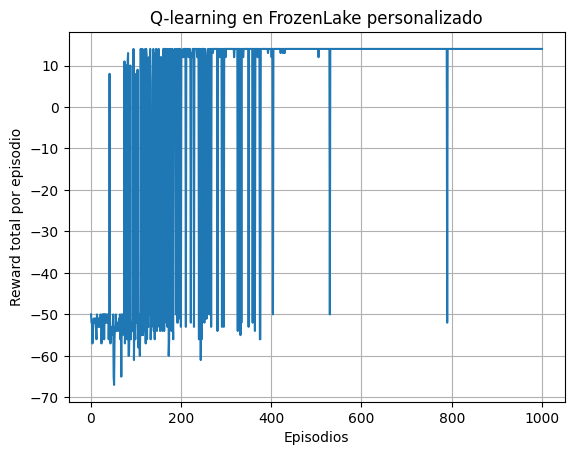

In [ ]:
episodes = np.arange(1, len(episode_rewards) + 1)

plt.figure()
plt.plot(episodes, episode_rewards)
plt.xlabel("Episodios")
plt.ylabel("Reward total por episodio")
plt.title("Q-learning en FrozenLake")
plt.grid(True)
plt.show()

# Cuantico

In [ ]:
import gymnasium as gym
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


## 1. Configuración del Ambiente y Qubits

In [6]:

matrix = ["SFHF", "HFFH", "HHFF", "GFFF"]
env = gym.make('FrozenLake-v1',render_mode="rgb_array", desc=matrix, map_name="4x4", is_slippery=False)
state = env.reset()


n_qubits = 4
n_actions = env.action_space.n 
n_states = env.observation_space.n

print("numero de estados: ",n_states)
print("numero de acciones: ",n_actions)

dev = qml.device("default.qubit", wires=n_qubits)

numero de estados:  16
numero de acciones:  4


## 2. Definición Manual del Circuito (Ansatz)

In [9]:
def entangling_layer(n_qubits, weights_layer):
    """
    Construye una capa de entrelazamiento manualmente.
    Reemplaza a StrongEntanglingLayers para evitar errores de importación.
    """
    # 1. Rotaciones paramétricas en cada qubit
    for i in range(n_qubits):
        # weights_layer[i] tiene 3 valores (phi, theta, omega) para la rotación general
        qml.Rot(weights_layer[i, 0], weights_layer[i, 1], weights_layer[i, 2], wires=i)
    
    # 2. Entrelazamiento (CNOTs en anillo)
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """
    inputs: Estado binario [0, 1, 0...]
    weights: Tensor de pesos (capas, qubits, 3)
    """
    # Codificación del estado (Basis Encoding)
    qml.BasisState(inputs, wires=range(n_qubits))
    
    # Aplicar capas variacionales manualmente
    # weights tiene forma (n_layers, n_qubits, 3)
    for layer_idx in range(weights.shape[0]):
        entangling_layer(n_qubits, weights[layer_idx])
    
    # Medición: Valores esperados en Z
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


## 3. Modelo Híbrido PyTorch

In [10]:
class QuantumQModel(nn.Module):
    def __init__(self, n_layers):
        super(QuantumQModel, self).__init__()
        self.n_layers = n_layers
        
        # Definimos la forma de los pesos: (capas, qubits, 3 parámetros por rotación)
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        
        # TorchLayer conecta PennyLane con PyTorch
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        
    def forward(self, state_index):
        # Convertir índice entero (ej: 5) a binario (ej: [0, 1, 0, 1])
        binary_string = format(state_index, f'0{n_qubits}b')
        binary_state = [int(x) for x in binary_string]
        
        input_tensor = torch.tensor(binary_state, dtype=torch.float32)
        output = self.q_layer(input_tensor)
        
        # Escalamos la salida [-1, 1] un poco para facilitar los Q-values
        return output

## 4. Entrenamiento (Q-Learning)

In [ ]:
# Hiperparámetros
n_layers = 3
lr = 0.05
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.1 # Mantenemos algo de exploración
episodes = 1000

model = QuantumQModel(n_layers)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

print(f"Iniciando entrenamiento en {dev.name} con {n_layers} capas manuales...")
rewards_per_episode = []

for episode in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        # --- Epsilon-Greedy ---
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values).item()
        
        # --- Step ---
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # --- Reward Shaping (Crucial para FrozenLake) ---
        real_reward = reward
        if terminated and reward == 0: 
            reward = -1.0 # Cayó al agujero
        elif reward == 0:
            reward = -0.01 # Costo por paso (evita bucles infinitos)
            
        done = terminated or truncated

        # --- Update ---
        optimizer.zero_grad()
        
        curr_q = model(state)[action]
        
        with torch.no_grad():
            if done:
                target = torch.tensor(reward, dtype=torch.float32)
            else:
                next_q = model(next_state)
                target = reward + gamma * torch.max(next_q)
        
        loss = loss_fn(curr_q, target)
        loss.backward()
        optimizer.step()
        
        state = next_state
        total_reward += real_reward # Guardamos el reward original para la gráfica
        
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
        
    rewards_per_episode.append(total_reward)
    
    if (episode + 1) % 50 == 0:
        avg_rew = np.mean(rewards_per_episode[-50:])
        print(f"Episodio {episode+1} - Promedio Reward (últimos 50): {avg_rew:.2f} - Epsilon: {epsilon:.2f}")

print("Entrenamiento completado.")


## 5. Visualización

Iniciando entrenamiento en default.qubit con 3 capas manuales...
Episodio 50 - Promedio Reward (últimos 50): 0.08 - Epsilon: 0.61
Episodio 100 - Promedio Reward (últimos 50): 0.10 - Epsilon: 0.37
Episodio 150 - Promedio Reward (últimos 50): 0.04 - Epsilon: 0.22
Episodio 200 - Promedio Reward (últimos 50): 0.18 - Epsilon: 0.13
Episodio 250 - Promedio Reward (últimos 50): 0.00 - Epsilon: 0.10
Episodio 300 - Promedio Reward (últimos 50): 0.00 - Epsilon: 0.10
Episodio 350 - Promedio Reward (últimos 50): 0.06 - Epsilon: 0.10
Episodio 400 - Promedio Reward (últimos 50): 0.08 - Epsilon: 0.10
Episodio 450 - Promedio Reward (últimos 50): 0.14 - Epsilon: 0.10
Episodio 500 - Promedio Reward (últimos 50): 0.22 - Epsilon: 0.10
Episodio 550 - Promedio Reward (últimos 50): 0.04 - Epsilon: 0.10
Episodio 600 - Promedio Reward (últimos 50): 0.02 - Epsilon: 0.10
Episodio 650 - Promedio Reward (últimos 50): 0.16 - Epsilon: 0.10
Episodio 700 - Promedio Reward (últimos 50): 0.06 - Epsilon: 0.10
Episodio 750

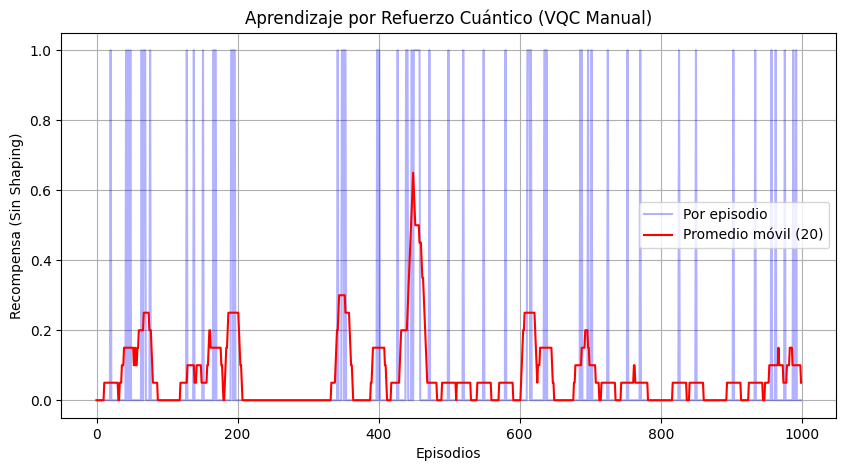


--- Test Final (Greedy) ---
Paso 0: Estado 0 -> Acción 2
Paso 1: Estado 1 -> Acción 0
Paso 2: Estado 0 -> Acción 2
Paso 3: Estado 1 -> Acción 0
Paso 4: Estado 0 -> Acción 2
Paso 5: Estado 1 -> Acción 0
Paso 6: Estado 0 -> Acción 2
Paso 7: Estado 1 -> Acción 0
Paso 8: Estado 0 -> Acción 2
Paso 9: Estado 1 -> Acción 0
Paso 10: Estado 0 -> Acción 2
Paso 11: Estado 1 -> Acción 0
Paso 12: Estado 0 -> Acción 2
Paso 13: Estado 1 -> Acción 0
Paso 14: Estado 0 -> Acción 2
Paso 15: Estado 1 -> Acción 0
Paso 16: Estado 0 -> Acción 2
Paso 17: Estado 1 -> Acción 0
Paso 18: Estado 0 -> Acción 2
Paso 19: Estado 1 -> Acción 0


In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, alpha=0.3, color='blue', label='Por episodio')
plt.plot(smooth(rewards_per_episode, 20), color='red', label='Promedio móvil (20)')
plt.title("Aprendizaje por Refuerzo Cuántico (VQC Manual)")
plt.xlabel("Episodios")
plt.ylabel("Recompensa (Sin Shaping)")
plt.legend()
plt.grid(True)
plt.show()

# Test final
print("\n--- Test Final (Greedy) ---")
state, _ = env.reset()
done = False
steps = 0
while not done and steps < 20:
    with torch.no_grad():
        action = torch.argmax(model(state)).item()
    print(f"Paso {steps}: Estado {state} -> Acción {action}")
    state, reward, term, trunc, _ = env.step(action)
    done = term or trunc
    steps += 1
    if reward == 1.0: print("¡Meta alcanzada!")
    if term and reward == 0.0: print("Caída en agujero.")
env.close()